In [1]:
using LinearAlgebra
using Plots
using Random

# Simplex Method with Bland's Anti-Cycling Rule

In [2]:
function pivot(B_idx,BinvA,x_B,cst,err)
    m, n+m = size(BinvA)
    ent = findfirst(cst.<0)[2]
    P_idx = findall(BinvA[:,ent].>0)
    if (length(P_idx) == 0)
        err = 1
        return B_idx, BinvA, x_B, cst, err
    end
    ext = P_idx[argmin(x_B[P_idx]./BinvA[P_idx,ent])]
    B_idx[findfirst(B_idx.==B_idx[ext])] = ent
    scale = BinvA[ext,ent]
    BinvA[ext,:] = BinvA[ext,:]/scale
    x_B[ext] = x_B[ext]/scale
    for i in setdiff(1:m,ext)
        scale = BinvA[i,ent]
        BinvA[i,:] = BinvA[i,:]-scale*BinvA[ext,:]
        x_B[i] = x_B[i]-scale*x_B[ext]
    end
    scale = cst[ent]
    cst = cst-scale*transpose(BinvA[ext,:])
    return B_idx, BinvA, x_B, cst, err
end

function initbfs(A,b;max_iter=10000)
    m, n = size(A)
    I_m = Matrix(I,m,m)
    A_aux = hcat(A,I_m)
    c_aux = vcat(zeros(n),ones(m))
    B_idx = collect(n+1:n+m)
    BinvA = inv(A_aux[:,B_idx])*A_aux
    x_B = inv(A_aux[:,B_idx])*b
    cst = vcat(zeros(n),ones(m))
    for i in 1:m
        cst = cst-BinvA[i,:]
    end
    cst = transpose(cst)
    err = 0
    iter = 0
    while (length(findall(cst.<0)) != 0)
        B_idx, BinvA, x_B, cst, err = pivot(B_idx,BinvA,x_B,cst,err)
        if (err == 1)
            return B_idx, BinvA, x_B, cst, err
        end
        iter = iter+1
        if (iter > max_iter)
            return B_idx, BinvA, x_B, cst, err
        end
    end
    x_bfs = zeros(n+m)
    x_bfs[B_idx] = x_B
    obj = dot(c_aux,x_bfs)
    if (obj > 0)
        err = 1
        return B_idx, BinvA, x_B, cst, err
    end
    return B_idx, BinvA, x_B, cst, err
end

function simplex(c,A,b;max_iter=10000)
    m, n = size(A)
    B_idx, BinvA, x_B, cst, err = initbfs(A,b;max_iter=max_iter)
    if (err == 1)
        print("INFEASIBLE\n")
        return -ones(n)
    end
    BinvA = inv(A[:,B_idx])*A
    cst = c
    for i in 1:m
        cst = cst-BinvA[i,:]
    end
    cst = transpose(cst)
    iter = 1
    x_list = zeros(0)
    x_curr = zeros(n)
    x_curr[B_idx] = x_B
    append!(x_list,x_curr)
    while (length(findall(cst.<0)) != 0)
        B_idx, BinvA, x_B, cst, err = pivot(B_idx,BinvA,x_B,cst,err)
        if (err == 1)
            print("UNBOUNDED\n")
            return -ones(n), x_list
        end
        iter = iter+1
        if (iter == max_iter)
            print("MAX ITERATIONS REACHED\n")
            return -ones(n), x_list
        end
        x_curr = zeros(n)
        x_curr[B_idx] = x_B
        append!(x_list,x_curr)
    end
    x_curr = zeros(n)
    x_curr[B_idx] = x_B
    n_iter = length(x_list)
    x_list = reshape(x_list,(n,Int(n_iter/n)))
    return x_curr, x_list
end

simplex (generic function with 1 method)

## Example 1: Linear Program

Example 1 in Section 3.4 of *Linear and Nonlinear Programming, 3rd Edition* by Luenberger and Ye. 

In [3]:
c = [-3;-1;-3;0;0;0]
A = [2 1 1 1 0 0;
     1 2 3 0 1 0;
     2 2 1 0 0 1]
b = [2;5;6]

x_opt, x_list = simplex(c,A,b)
print("x_opt: ",x_opt,"\n")
print("f_opt: ",dot(c,x_opt),"\n")
print("iters: ",size(x_list)[2])

x_opt: [0.2, 0.0, 1.6, 0.0, 0.0, 4.0]
f_opt: -5.4
iters: 5

The output matches the book's solution.

## Example 2: Zero-Sum Game

We formulate the zero-sum game rock-paper-scisscors as a linear program. Recall that the payoff matrix of this game is

| Action | Rock | Paper | Scissors |
| --- | --- | --- | --- |
| **Rock** | (0,0) | (-1,1) | (1,-1) |
| **Paper** | (1,-1) | (0,0) | (-1,1) |
| **Scissors** | (-1,1) | (1,-1) | (0,0) |

The LP formulation of the game is shown below. The first three variables represent probability masses on each strategy, the fourth variable represents utility, and the last five are slack variables. The first three constraints represent minimax constraints, and the next two force the probability masses to add up to 1.

In [4]:
c = [0;0;0;-1;0;0;0;0;0]
A = [ 0 -1  1 1 1 0 0 0 0;
      1  0 -1 1 0 1 0 0 0;
     -1  1  0 1 0 0 1 0 0;
      1  1  1 0 0 0 0 1 0;
     -1 -1 -1 0 0 0 0 0 1]
b = [0;0;0;1;-1]

x_opt, x_list = simplex(c,A,b)
print("x_opt: ",x_opt,"\n")
print("f_opt: ",dot(c,x_opt),"\n")
print("iters: ",size(x_list)[2])

x_opt: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.8503717077085938e-17, 0.0, 0.0, 0.0, 0.0, 0.0]
f_opt: -1.8503717077085938e-17
iters: 8

We see that the minimax and Nash equilibrium strategy for each player is to play each action (rock, paper, scissors) with equal probability, and that the expected utility of this game is zero under this strategy, which is consistent with an analytical analysis of this game.

## Convergence Rate of a Large Random LP

x_opt: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025972448387397252, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035863456156396974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011084321837115607, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03736806439869286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04568747462235972, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010793103738141607, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07045144184886655, 0.15425312591811186, 0.6209206166259229, 0.2233924857013036, 0.0, 0.5352018975418282, 0.2972010968564577, 0.4907755222315

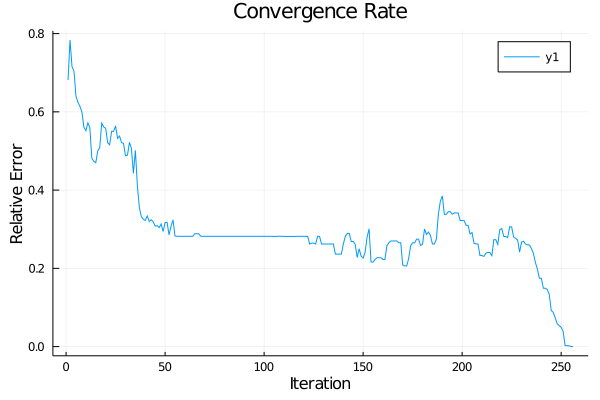

In [5]:
Random.seed!(1)
n = 150
m = 100
c = -rand(n)
A = rand(m,n)
b = rand(m)

c_aug = vcat(c,zeros(m))
A_aug = hcat(A,Matrix(I,m,m))

x_opt, x_list = simplex(c_aug,A_aug,b)

f_opt = dot(c_aug,x_opt)
conv = zeros(size(x_list)[2])
for i in 1:length(conv)
    conv[i] = abs(dot(c_aug,x_list[:,i])-f_opt)/abs(f_opt)
end

print("x_opt: ",x_opt,"\n")
print("f_opt: ",dot(c_aug,x_opt),"\n")
print("iters: ",size(x_list)[2])

plot(conv,title="Convergence Rate",xlabel="Iteration",ylabel="Relative Error")